# Ke and Ce implementation

This notebook implements the 2x2 stiffness-like matrix Ke and the 2x2 damping-like matrix Ce from the formulas provided.

We implement a function `compute_ke_ce(eps, fc=1.0)` which returns (Ke, Ce) as NumPy arrays and performs basic domain checks.

Assumptions / notes:
- The user-provided formulas are implemented as described. For one ambiguous fraction in the `avv` term we used the interpretation where the factor `32 eps^2 (1+eps^2)` is divided by `(1 - eps^2)`. If you intended a different placement of parentheses, tell me and I'll adjust.
- The valid range for `eps` is 0 < |eps| < 1 to avoid division-by-zero or sqrt of a negative.

## Background on Hydrodynamic Bearings and Stiffness/Damping Matrices

The stiffness-like matrix $K_e$ and damping-like matrix $C_e$ are derived from the behavior of hydrodynamic bearings under certain assumptions. These bearings, which support rotating shafts, rely on a thin film of lubricant to carry loads and reduce friction. The derivation assumes:

- Laminar flow and applicability of Reynolds's equation.
- A very short bearing (length-to-diameter ratio $L/D \ll 1$).
- Constant lubricant properties and steady operating conditions.
- No shaft tilt within the bearing.

### Key Equations

The force components on the journal due to the bearing are expressed as:

$$
\begin{aligned}
    f_r &= -\frac{D \eta L^3 \varepsilon^2}{2 c^2 (1 - \varepsilon^2)^2}, \\
    f_t &= -\frac{\pi D \eta L^3 \varepsilon}{8 c^2 (1 - \varepsilon^2)^{3/2}},
\end{aligned}
$$

where $\eta$ is the lubricant viscosity, $\varepsilon$ is the eccentricity, $c$ is the radial clearance, and $L$ and $D$ are the bearing length and diameter, respectively. The resultant force magnitude $f$ is:

$$
    f = \frac{\pi D \eta L^3 \varepsilon}{8 c^2 (1 - \varepsilon^2)} \sqrt{\left(\frac{16}{\pi^2} - 1\right) \varepsilon^2 + 1}.
$$

### Stiffness and Damping Matrices

For small displacements, the force-displacement relationship can be linearized, leading to the stiffness and damping matrices:

$$
K_e = \frac{f}{c} \begin{bmatrix}
    a_{uu} & a_{uv} \\
    a_{vu} & a_{vv}
\end{bmatrix}, \quad
C_e = \frac{f}{c \Omega} \begin{bmatrix}
    b_{uu} & b_{uv} \\
    b_{vu} & b_{vv}
\end{bmatrix},
$$

where $\Omega$ is the angular velocity. The coefficients $a_{ij}$ and $b_{ij}$ are functions of $\varepsilon$ and $h_0$, a factor dependent on the bearing geometry and lubricant properties:

$$
    h_0 = \frac{1}{\left(\pi^2 (1 - \varepsilon^2) + 16 \varepsilon^2\right)^{3/2}}.
$$

### Implementation Notes

The Python function `compute_ke_ce` implements these matrices, ensuring domain checks for $0 < |\varepsilon| < 1$ to avoid singularities. The formulas are directly translated into code, with careful handling of terms involving $\sqrt{1 - \varepsilon^2}$ and divisions by $\varepsilon$. For further details, refer to Hamrock et al. (2004) and Smith (1969).

In [16]:
# Implementation of Ke and Ce from the provided formulas
import numpy as np
from typing import Tuple

def compute_ke_ce(eps: float, fc: float = 1.0, Omega: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Compute Ke and Ce matrices for given eccentricity `eps` and scalar `fc`.

    Returns:
        (Ke, Ce): two 2x2 numpy arrays.

    Notes:
    - Requires 0 < |eps| < 1 to avoid singularities (division by eps or sqrt of negative).
    - The implementation follows the formulas given; `avv` uses the interpretation where the `32*eps^2*(1+eps^2)` term is divided by `(1 - eps**2)`.
    """
    eps = float(eps)
    if not (0.0 < abs(eps) < 1.0):
        raise ValueError(
            "eps must satisfy 0 < |eps| < 1 (avoid eps=0 and |eps|>=1 which produce singularities)"
        )

    pi = np.pi
    s = np.sqrt(1.0 - eps**2)

    # common factor h0 = 1 / ( (pi^2 (1 - eps^2) + 16 eps^2)^(3/2) )
    denom_common = (pi**2 * (1.0 - eps**2) + 16.0 * eps**2)
    h0 = 1.0 / (denom_common ** 1.5)

    # a-coefficients (Ke = fc * [[a_uu, a_uv],[a_vu, a_vv]])
    a_uu = h0 * 4.0 * (pi**2 * (2.0 - eps**2) + 16.0 * eps**2)
    a_uv = h0 * pi * (pi**2 * (1.0 - eps**2)**2 - 16.0 * eps**4) / (eps * s)
    a_vu = -h0 * pi * (pi**2 * (1.0 - eps**2) * (1.0 + 2.0 * eps**2) + 32.0 * eps**2 * (1.0 + eps**2)) / (eps * s)
    # avv interpretation: 4 * ( pi^2 (1+2 eps^2) + 32 eps^2 (1+eps^2) / (1 - eps^2) )
    a_vv = h0 * 4.0 * (pi**2 * (1.0 + 2.0 * eps**2) + 32.0 * eps**2 * (1.0 + eps**2) / (1.0 - eps**2))

    # b-coefficients (Ce = fc * [[b_uu, b_uv],[b_vu, b_vv]])
    b_uu = h0 * 2.0 * pi * s * (pi**2 * (1.0 + 2.0 * eps**2) - 16.0 * eps**2) / eps
    b_uv = -h0 * 8.0 * (pi**2 * (1.0 + 2.0 * eps**2) - 16.0 * eps**2)
    b_vu = b_uv
    b_vv = h0 * 2.0 * pi * (pi**2 * (1.0 - eps**2)**2 + 48.0 * eps**2) / (eps * s)

    Ke = fc * np.array([[a_uu, a_uv], [a_vu, a_vv]], dtype=float)
    Ce = fc / Omega * np.array([[b_uu, b_uv], [b_vu, b_vv]], dtype=float)

    return Ke, Ce

# Quick demo values when the cell is executed interactively:
if __name__ == '__main__':
    eps_demo = 0.3
    fc_demo = 1.0
    Ke_demo, Ce_demo = compute_ke_ce(eps_demo, fc_demo)
    print('eps =', eps_demo, 'fc =', fc_demo)
    print('Ce =')
    print(Ce_demo)
    print('Ke =')
    print(Ke_demo)

eps = 0.3 fc = 1.0
Ce =
[[ 6.06115225 -2.42697817]
 [-2.42697817  8.15304771]]
Ke =
[[ 2.41255323  2.62460099]
 [-4.48249899  1.79486124]]


In [13]:
def solve_quartic(Ss: float) -> float:
    """
    Solve the quartic equation for ε^2:
    ε^8 − 4ε^6 + (6 − S_s^2 (16 − π^2)) ε^4 − (4 + π^2 S_s^2) ε^2 + 1 = 0

    Args:
        Ss (float): Modified Sommerfeld number.

    Returns:
        float: The valid root for ε^2 (real and between 0 and 1).
    """
    pi = np.pi

    # Quartic equation coefficients
    coeffs = [
        1,  # ε^8
        -4,  # ε^6
        6 - Ss**2 * (16 - pi**2),  # ε^4
        -(4 + pi**2 * Ss**2),  # ε^2
        1  # Constant term
    ]

    # Solve the quartic equation
    roots = np.roots(coeffs)

    # Find the valid root for ε^2 (real and between 0 and 1)
    eps_squared = next(root.real for root in roots if root.imag == 0 and 0 < root.real < 1)

    return eps_squared

In [14]:
def compute_eps(diameter: float, length: float, load: float, clearance: float,
                viscosity: float, speed_rpm: float) -> Tuple[float, float, float]:

    # Convert speed to rad/s
    omega = speed_rpm * 2 * np.pi / 60  # rad/s

    # Calculate modified Sommerfeld number (Ss)
    Ss = (diameter * omega * viscosity * length**3) / (8 * load * clearance**2)

    # Calculate Sommerfeld number (S)
    S = Ss / np.pi * ((diameter / length)**2)

    # Solve quartic equation for eccentricity squared (eps^2)
    # Quartic equation coefficients from the problem statement
    eps_squared = solve_quartic(Ss)
    eps = np.sqrt(eps_squared)
    
    return eps, Ss, S


In [38]:
def compute_bearing_number(mu, omega, pa, R, c):
    """
    Compute the dimensionless parameter Lambda (Λ) for hydrodynamic lubrication.

    Args:
        mu (float): Dynamic viscosity of the lubricant (Pa·s).
        omega (float): Angular velocity of the journal (rad/s).
        pa (float): Ambient pressure (Pa).
        R (float): Radius of the journal (m).
        c (float): Radial clearance (m).

    Returns:
        float: The computed value of Λ.
    """
    return (6 * mu * omega * (R / c)**2) / pa

In [ ]:
def compute_squeeze_number(mu, nu, pa, R, c):
    """
    Compute the squeeze number (σ) for hydrodynamic lubrication.

    Args:
        mu (float): Dynamic viscosity of the lubricant (Pa·s).
        nu (float): perturbation frequency.
        pa (float): Ambient pressure (Pa).
        R (float): Radius of the journal (m).
        c (float): Radial clearance (m).

    Returns:
        float: The computed value of σ.
    """
    return (12 * mu * nu * (R / c)**2) / pa

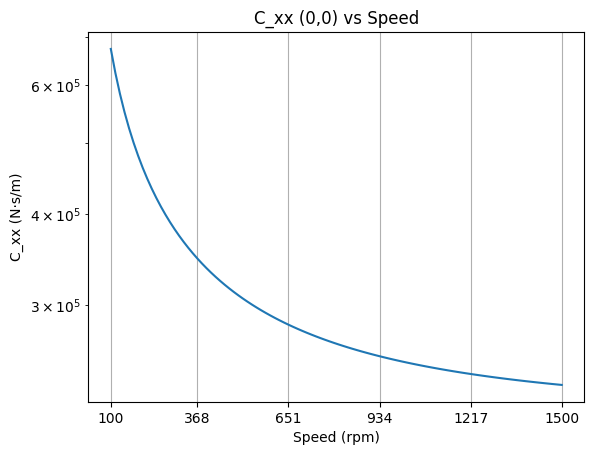

In [ ]:

# Example 5.5.1: Oil Film Bearing Analysis

# Given parameters
diameter = 0.1  # meters
length = 0.03  # meters
load = 525  # Newtons
clearance = 0.1e-3  # meters
viscosity = 0.1  # Pa.s
speed_rpm = np.linspace(100, 1500, 100)  # rpm
nu = np.linspace(0.1, 100, 100)  # perturbation frequency
ambient_pressure = 101325  # Pa (1 atm)

Cxx_Mat = []
for rpm in speed_rpm:
    # Compute eccentricity, modified Sommerfeld number, and Sommerfeld number
    eps, Ss, S = compute_eps(diameter, length, load, clearance, viscosity, rpm)
    # Compute stiffness and damping matrices using the provided function
    Ke, Ce = compute_ke_ce(eps, load / clearance, Omega=rpm * 2 * np.pi / 60)
    Cxx_Mat.append(Ce[0,0])
    
import matplotlib.pyplot as plt
rpm_vals = np.linspace(100, 1500, 100)
idx = np.arange(len(rpm_vals))

plt.figure()

Lambda = compute_bearing_number(mu=viscosity, omega=speed_rpm * 2 * np.pi / 60, pa=ambient_pressure, R=diameter/2, c=clearance)

tick_idx = np.linspace(0, len(idx) - 1, 6, dtype=int)

plt.xlabel('Speed (rpm)')
plt.ylabel('C_xx (N·s/m)')
plt.title('C_xx (0,0) vs Speed')
plt.grid(True)
plt.semilogy(Cxx_Mat)


In [18]:

# Example 5.5.1: Oil Film Bearing Analysis

# Given parameters
diameter = 0.1  # meters
length = 0.03  # meters
load = 525  # Newtons
clearance = 0.1e-3  # meters
viscosity = 0.1  # Pa.s
speed_rpm = 1500  # revolutions per minute


eps, Ss, S = compute_eps(diameter, length, load, clearance, viscosity, speed_rpm)
# Compute stiffness and damping matrices using the provided function
Ke, Ce = compute_ke_ce(eps, load / clearance, Omega=speed_rpm * 2 * np.pi / 60)

# Display results
print("Example 5.5.1 Results:")
print(f"Eccentricity (eps): {eps:.4f}")
print(f"Modified Sommerfeld number (Ss): {Ss:.3f}")
print(f"Sommerfeld number (S): {S:.3f}\n")

print("Stiffness matrix (Ke) [MN/m]:")
print(Ke / 1e6)  # Convert to MN/m

print("\nDamping matrix (Ce) [kNs/m]:")
print(Ce / 1e3)  # Convert to kNs/m

Example 5.5.1 Results:
Eccentricity (eps): 0.2663
Modified Sommerfeld number (Ss): 1.010
Sommerfeld number (S): 3.571

Stiffness matrix (Ke) [MN/m]:
[[ 12.80795958  16.39359325]
 [-25.06039328   8.81530274]]

Damping matrix (Ce) [kNs/m]:
[[232.89692987 -81.92437052]
 [-81.92437052 294.91161944]]
